# Summary

```Objective```

- Check if torchio random-affine transform can be inverted
- This will be used for contrastive learning  in `CoMIR: Contrastive Multimodal Image Representation for Registration`
- 

```Methods```

use torch.io RandomAffine

```Results```

todo

# Config

In [73]:
spatial_dims=2
in_channels = 1
out_channels = 1
num_res_blocks = (2, 2)
num_channels = (64, 128)
latent_channels = 3
num_slices_for_train = 100

perceptual_weight = 0.05

kl_weight = 1e-6
nce_weight = 5e-3

n_epochs = 500
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

# Libs

In [50]:

%load_ext autoreload
%autoreload 2

import torch
import time
import random

from tqdm import tqdm

from matplotlib import pyplot as plt
from torchvision import transforms
from ipywidgets import interact

from misalign.models.components.autoencoder_kl import AutoencoderKL, Encoder
from misalign.models.components.perceptual import PerceptualLoss

from misalign.data.components.transforms import dataset_IXI
from torch.utils.data import DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis

In [51]:
train_dataset = torch.utils.data.Subset(dataset_IXI(data_dir='/home/kanghyun/misalign-benchmark/data/IXI/val/prepared_data_0.0_0.0.h5', flip_prob=0.5, rot_prob=0.5, crop_prob=0.9), (range(50, num_slices_for_train + 50))) # use only 100 slices
train_loader = DataLoader(dataset=train_dataset, batch_size=1, num_workers=5, pin_memory=True, shuffle=True)

val_dataset = torch.utils.data.Subset(dataset_IXI(data_dir='/home/kanghyun/misalign-benchmark/data/IXI/test/prepared_data_0.0_0.0.h5', flip_prob=0.0, rot_prob=0.0, crop_prob=0.0), (range(0,50)))
val_loader = DataLoader(dataset=val_dataset, batch_size=1, num_workers=5, pin_memory=True, shuffle=False)

print(len(train_dataset), len(val_dataset))

100 50


In [52]:
%matplotlib inline

@interact(slice=(0,80,1), mixin=(0,1.0,0.1), brightness=(0.0,2.0,0.01), contrast=(0.0,10.0,0.05))
def f(slice, mixin, brightness=1.0, contrast=1.0):
    x, y = train_dataset[slice]
    image_tensor  = mixin * x + (1-mixin) * y
    image_tensor = (image_tensor + 1) / 2.0

    mean = torch.mean(image_tensor)
    image_tensor = (image_tensor - mean) * contrast + mean
    image_tensor = image_tensor * brightness
    
    image_tensor = torch.clamp(image_tensor, 0, 1)
    image_tensor = image_tensor * 2.0 - 1

    to_pil = transforms.ToPILImage()
    image_contrast_brightness_adjusted = to_pil((image_tensor + 1) / 2.0)  # convert to [0,1] for PIL

    # Show the image
    plt.imshow(image_contrast_brightness_adjusted, cmap='gray')
    plt.show()



interactive(children=(IntSlider(value=40, description='slice', max=80), FloatSlider(value=0.5, description='mi…

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
model = AutoencoderKL(
    in_channels=in_channels,
    out_channels=out_channels,
    num_res_blocks=num_res_blocks,
    num_channels=num_channels,
    latent_channels=latent_channels,
)
model.to(device)

perceptual_loss = PerceptualLoss(spatial_dims=spatial_dims, network_type="radimagenet_resnet50")
perceptual_loss.to(device)

Using cuda


PerceptualLoss(
  (perceptual_function): RadImageNetPerceptualSimilarity(
    (model): ResNet50(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn1): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn2): BatchNorm2d(64, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (bn3): BatchNorm2d(256, eps=1.001e-05, momentum=0.99, affine=True, track_running_stats=True)
          (relu)

In [75]:
optimizer_g = torch.optim.Adam(params=model.parameters(), lr=1e-4)
l1_loss = torch.nn.L1Loss()

In [76]:
def random_rotate(image):
    rotations = [
        0,
        1,
        2,
        3,
    ]  # 0: 0 degrees, 1: 90 degrees, 2: 180 degrees, 3: 270 degrees
    num_rotations = random.choice(rotations)
    return (
        torch.rot90(image, num_rotations, [-1, -2]),
        -num_rotations,
    )  # Rotating in opposite direction after passing through the model


def random_rotate_flip_scale(image):
    rotations = [
        0,
        1,
        2,
        3,
    ]  # 0: 0 degrees, 1: 90 degrees, 2: 180 degrees, 3: 270 degrees
    num_rotations = random.choice(rotations)

    # Flip along x, y or both randomly
    flips = [
        None,
        [-1],
        [-2],
        [-1, -2],
    ]  # None: no flip, -1: flip along x, -2: flip along y, [-1, -2]: flip along both x and y
    flip_dims = random.choice(flips)
    scale = random.uniform(0.7, 1.3)

    rotated_image = torch.rot90(image, num_rotations, [-1, -2])
    if flip_dims is not None:
        rotated_image = torch.flip(rotated_image, flip_dims)
    rotated_image = rotated_image * scale

    return (
        rotated_image,
        -num_rotations,
        flip_dims,
        scale
    )  # Also return the flip dimensions for reversing

In [77]:
cross_entropy_loss = torch.nn.CrossEntropyLoss()

# Input: f_q (BxCxS) and sampled features from H(G_enc(x))
# Input: f_k (BxCxS) are sampled features from H(G_enc(G(x))
# Input: tau is the temperature used in PatchNCE loss.
# Output: PatchNCE loss
def PatchNCELoss(f_q, f_k, tau=0.07):
    # batch size, channel size, and number of sample locations
    B, C, S = f_q.shape

    # calculate v * v+: BxSx1
    l_pos = (f_k * f_q).sum(dim=1)[:, :, None]

    # calculate v * v-: BxSxS
    l_neg = torch.bmm(f_q.transpose(1, 2), f_k)

    # The diagonal entries are not negatives. Remove them.
    identity_matrix = torch.eye(S, device=f_q.device, dtype= torch.bool)[None, :, :]
    l_neg.masked_fill_(identity_matrix, -10.0)

    # calculate logits: (B)x(S)x(S+1)
    logits = torch.cat((l_pos, l_neg), dim=2) / tau

    # return PatchNCE loss
    predictions = logits.flatten(0, 1)
    targets = torch.zeros(B * S, dtype=torch.long, device=f_q.device)
    return cross_entropy_loss(predictions, targets)

Epoch 0: 100%|█████████| 100/100 [00:07<00:00, 12.60it/s, recon=0.171, kl=0.00576, nce=0.0375, percep=0.00898]


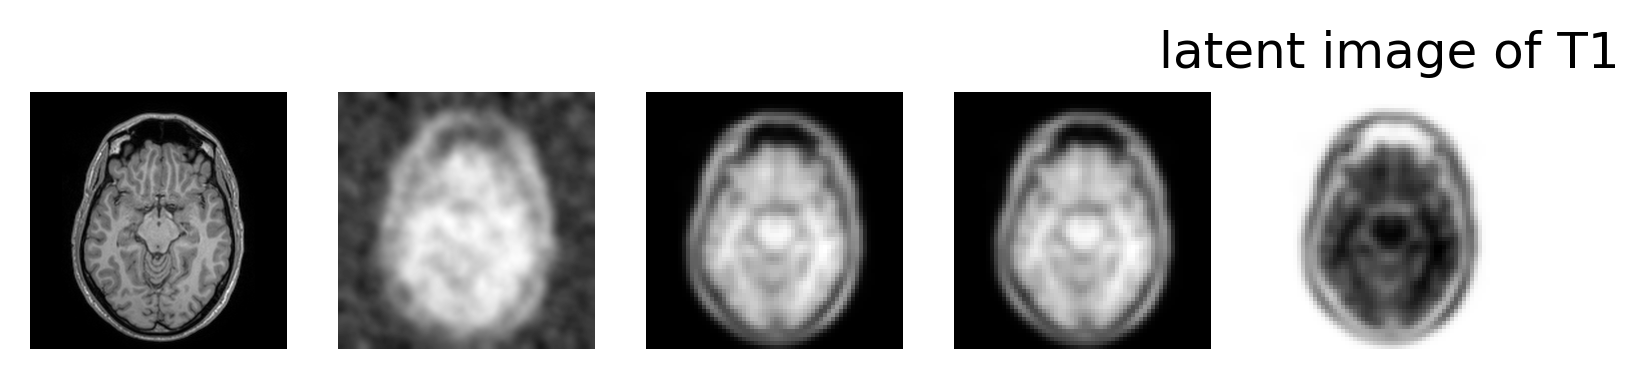

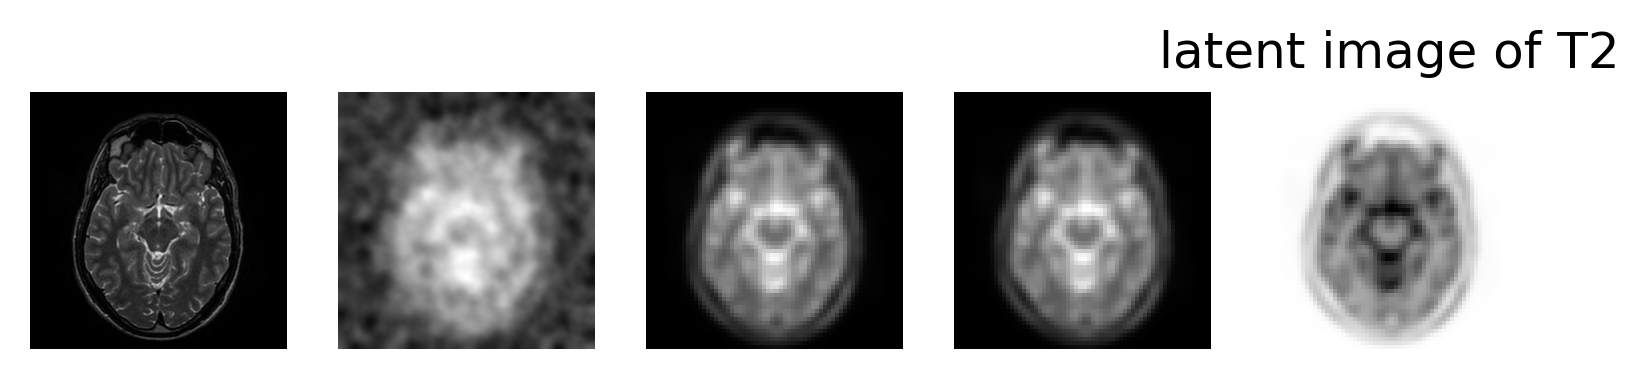

Epoch 10: 100%|██████| 100/100 [00:06<00:00, 14.31it/s, recon=0.0625, kl=0.00915, nce=0.0357, percep=0.000481]


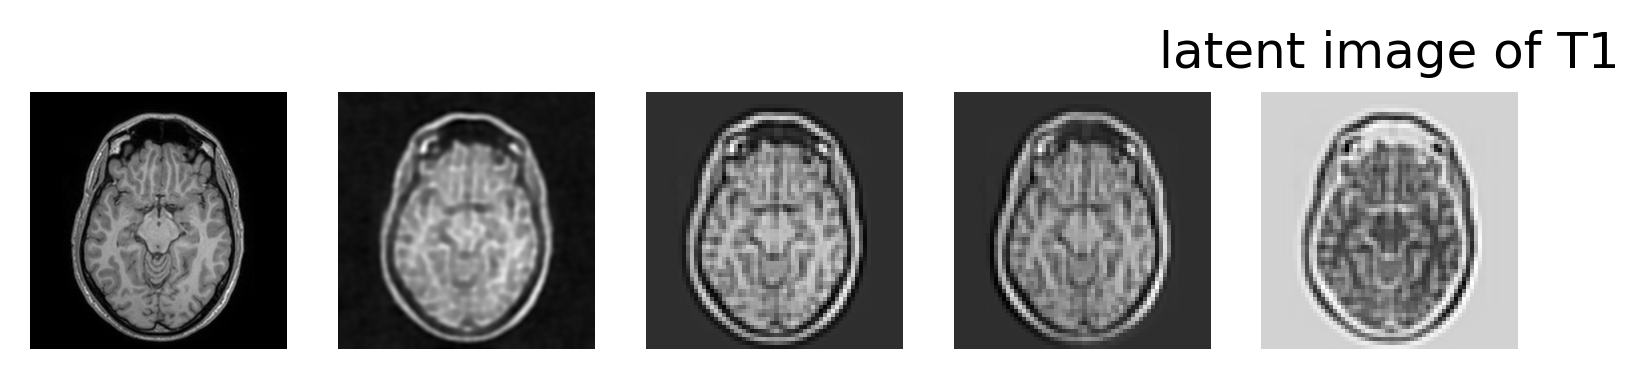

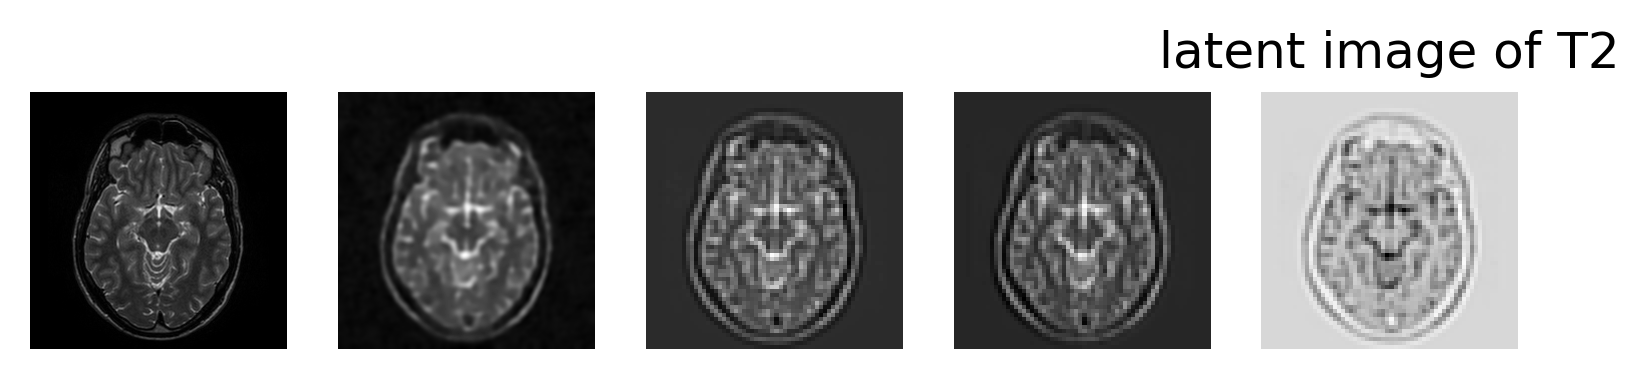

Epoch 20: 100%|███████| 100/100 [00:06<00:00, 14.90it/s, recon=0.0521, kl=0.00913, nce=0.0347, percep=0.00021]


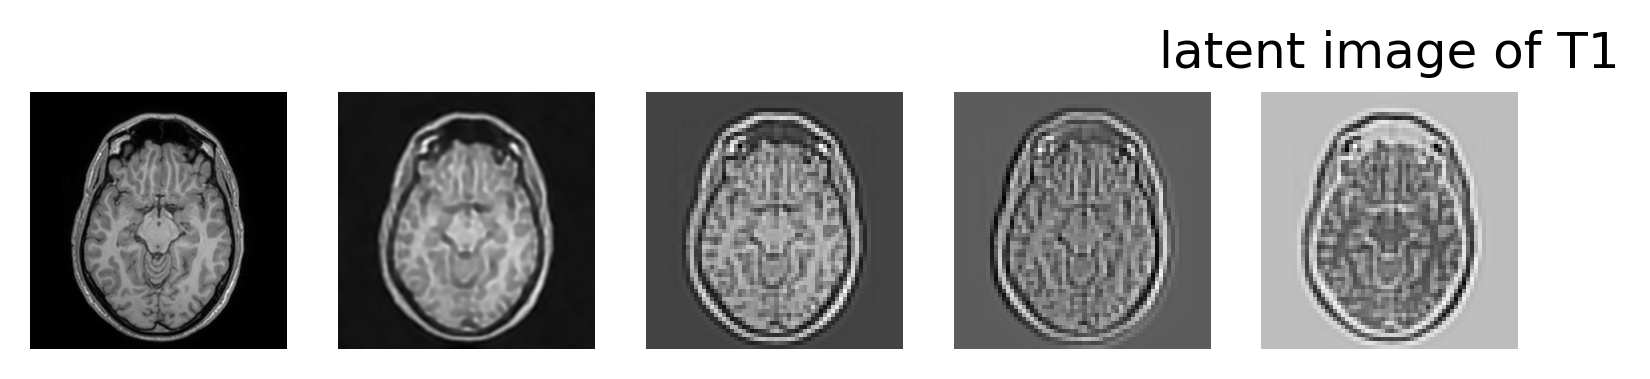

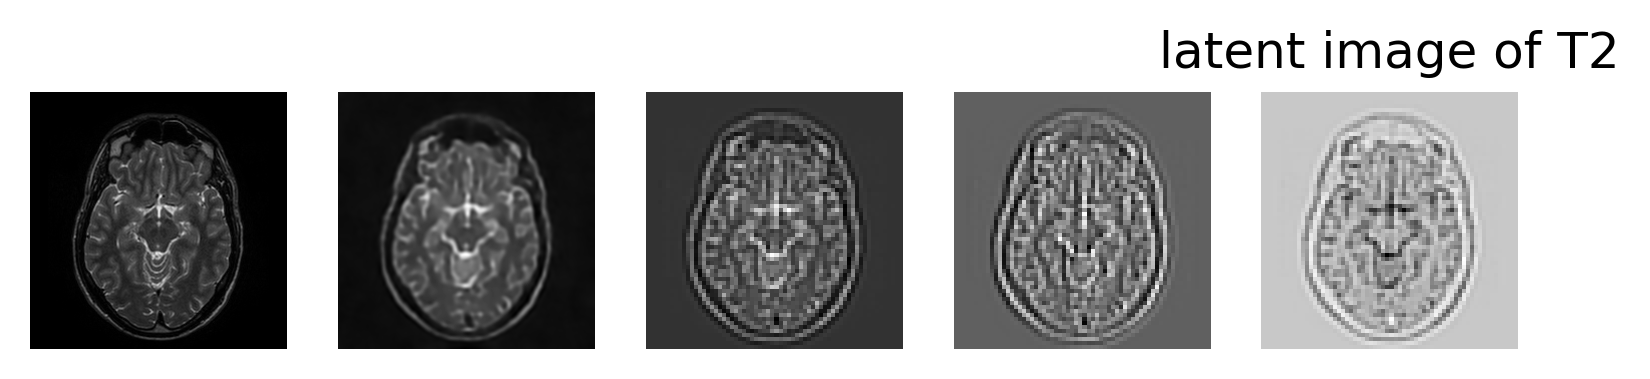

Epoch 21:  67%|████▋  | 67/100 [00:04<00:02, 13.86it/s, recon=0.0519, kl=0.00962, nce=0.0341, percep=0.000231]


KeyboardInterrupt: 

In [78]:
# without Contrastive Loss


total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    recon_epoch_loss = 0
    kl_epoch_loss = 0
    nce_epoch_loss = 0
    p_epoch_loss = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        x, y = batch
        mixin = torch.rand(1)
        images = mixin * x + (1 - mixin) * y

#        mixin = torch.rand(1)
        images2 = mixin * x + (1 - mixin) * y

        if images.shape[-1] % 16 != 0 or images.shape[-2] % 16 != 0:
            new_height = images.shape[-2] - (images.shape[-2] % 16)
            new_width = images.shape[-1] - (images.shape[-1] % 16)
            # Perform the cropping
            images = images[..., :new_height, :new_width]
            images2 = images2[..., :new_height, :new_width]

        images = images.to(device)
        images2 = images2.to(device)

        optimizer_g.zero_grad(set_to_none=True)

        reconstruction, mu, sigma, z_mu = model(images)

        # This part is for PatchNCE Loss

        rotated_flipped_images, reverse_rotations, flip_dims_list, scale_list = zip(
            *[random_rotate_flip_scale(img) for img in images]
        )

        rotated_flipped_images = torch.stack(rotated_flipped_images)

        # Pass rotated images through the model
        _, _, _, rot_z_mu = model(rotated_flipped_images)

        reverse_rotated_z_mu = torch.rot90(rot_z_mu, reverse_rotations[0], [-1, -2])
        if flip_dims_list[0] is not None:
            reverse_rotated_z_mu = torch.flip(reverse_rotated_z_mu, flip_dims_list[0]) / scale_list[0]

        f_q = reverse_rotated_z_mu.reshape(
            reverse_rotated_z_mu.shape[0], reverse_rotated_z_mu.shape[1], -1
        )

        # rotate image or flip and back again
        # Rotate the images

        rotated_flipped_images, reverse_rotations, flip_dims_list, scale_list = zip(
            *[random_rotate_flip_scale(img) for img in images2]
        )

        # Convert list of tensors to tensor
        rotated_flipped_images = torch.stack(rotated_flipped_images)

        # Pass rotated images through the model
        _, _, _, rot_z_mu = model(rotated_flipped_images)
        reverse_rotated_z_mu = torch.rot90(rot_z_mu, reverse_rotations[0], [-1, -2])

        if flip_dims_list[0] is not None:
            reverse_rotated_z_mu = torch.flip(reverse_rotated_z_mu, flip_dims_list[0])  / scale_list[0]

        f_k = reverse_rotated_z_mu.reshape(
            reverse_rotated_z_mu.shape[0], reverse_rotated_z_mu.shape[1], -1
        )

        nce_loss = PatchNCELoss(f_q, f_k, tau=0.07)

        recons_loss = l1_loss(reconstruction.float(), images.float())

        kl_loss = 0.5 * torch.sum(
            mu.pow(2) + sigma.pow(2) - torch.log(sigma.pow(2)) - 1, dim=[1, 2, 3]
        )
        kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
        p_loss = perceptual_loss(reconstruction.float(), images.float())

        loss_g = (
            recons_loss
            + kl_weight * kl_loss
            + perceptual_weight * p_loss
            + nce_loss * 0.01
        )

        loss_g.backward()
        optimizer_g.step()

        recon_epoch_loss += recons_loss.item()
        kl_epoch_loss += kl_loss.item() * kl_weight
        nce_epoch_loss += nce_loss.item() * nce_weight
        p_epoch_loss += p_loss.item() * perceptual_weight

        progress_bar.set_postfix(
            {
                "recon": recon_epoch_loss / (step + 1),
                "kl": kl_epoch_loss / (step + 1),
                "nce": nce_epoch_loss / (step + 1),
                "percep": p_epoch_loss / (step + 1),
            }
        )

    epoch_recon_loss_list.append(recon_epoch_loss / (step + 1))

    if (epoch) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                x, y = batch
                reconstruction, latent_img, _, _ = model(x.to(device))
                if val_step == 30:
                    plt.figure(dpi=300)
                    plt.subplot(1, latent_img.shape[1] + 2, 1)
                    plt.imshow(x[0, 0].detach().cpu(), cmap="gray")
                    plt.axis("off")

                    plt.subplot(1, latent_img.shape[1] + 2, 2)
                    plt.imshow(reconstruction[0, 0].detach().cpu(), cmap="gray")
                    plt.axis("off")

                    for _d in range(latent_img.shape[1]):
                        plt.subplot(1, latent_img.shape[1] + 2, _d + 3)
                        plt.imshow(latent_img[0, _d].detach().cpu(), cmap="gray")
                        plt.axis("off")
                    plt.title("latent image of T1")
                    plt.show()

                reconstruction, latent_img, _, _ = model(y.to(device))
                if val_step == 30:
                    plt.figure(dpi=300)
                    plt.subplot(1, latent_img.shape[1] + 2, 1)
                    plt.imshow(y[0, 0].detach().cpu(), cmap="gray")
                    plt.axis("off")

                    plt.subplot(1, latent_img.shape[1] + 2, 2)
                    plt.imshow(reconstruction[0, 0].detach().cpu(), cmap="gray")
                    plt.axis("off")
                    for _d in range(latent_img.shape[1]):
                        plt.subplot(1, latent_img.shape[1] + 2, _d + 3)
                        plt.imshow(latent_img[0, _d].detach().cpu(), cmap="gray")
                        plt.axis("off")
                    plt.title("latent image of T2")
                    plt.show()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [79]:
# Saving model
encoder = model.encoder
torch.save(encoder.state_dict(), "encoder_pretrain.pth")

# Loading it to model
encoder = Encoder(in_channels=1, num_channels=num_channels, out_channels=num_channels[-1], num_res_blocks=num_res_blocks)  # You need to define the Encoder class somewhere
# Load the state dict
encoder.load_state_dict(torch.load("encoder_pretrain.pth"))
encoder = encoder.to(device)

In [80]:
# Check rotational equivariance

# im -> encoder -> latent
# rot(im) -> encoder -> rot^-1(latent)
# check if two are the same
im1, im2 = val_dataset[40]
im = im2[None].to(device)

with torch.no_grad():
    out = encoder(im, return_intermediate=True)

print(out.keys())

dict_keys(['downsample_layer_1', 'downsample_layer_2'])


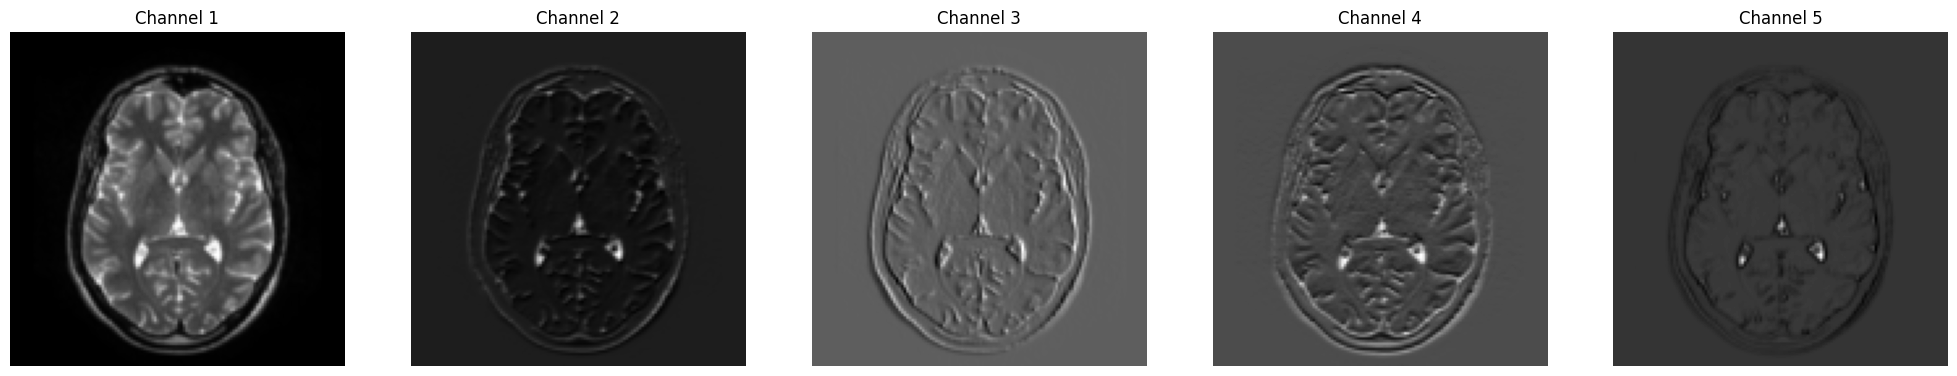

In [81]:
imshow_latent_images(out['downsample_layer_1'])

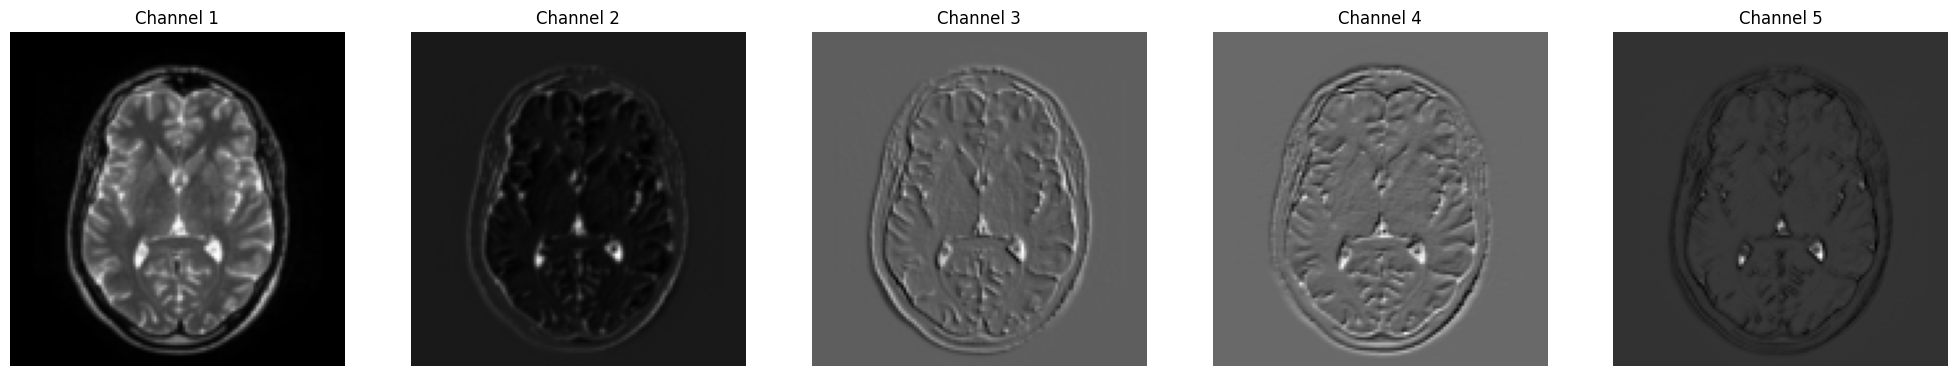

In [70]:
imshow_latent_images(out['downsample_layer_1'])

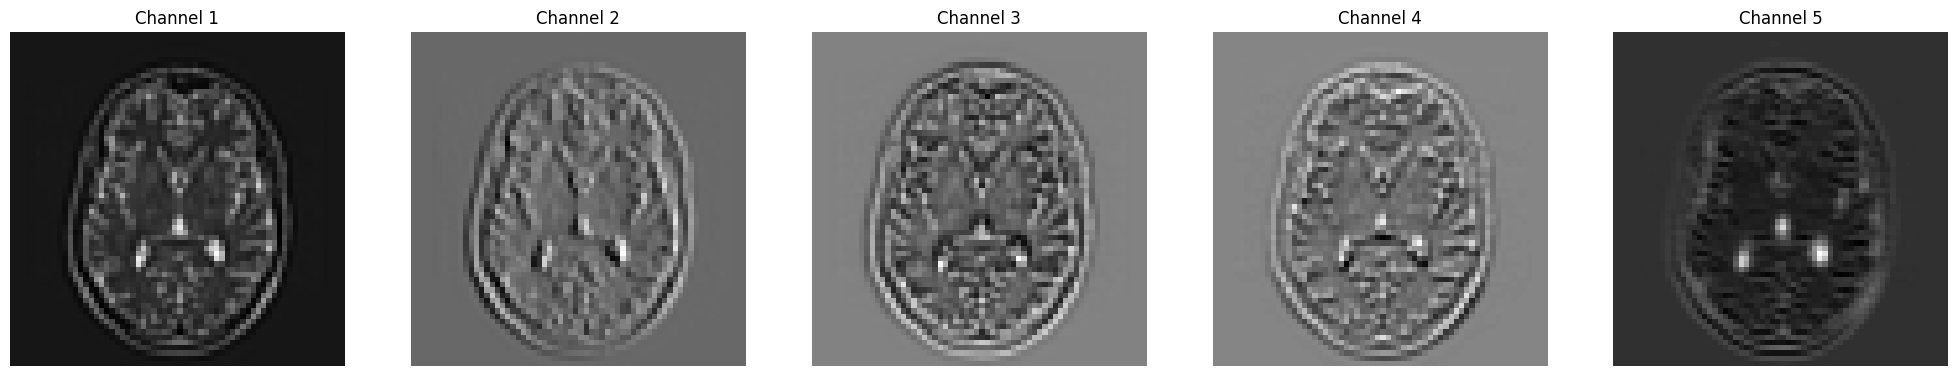

In [82]:
imshow_latent_images(out['downsample_layer_2'])

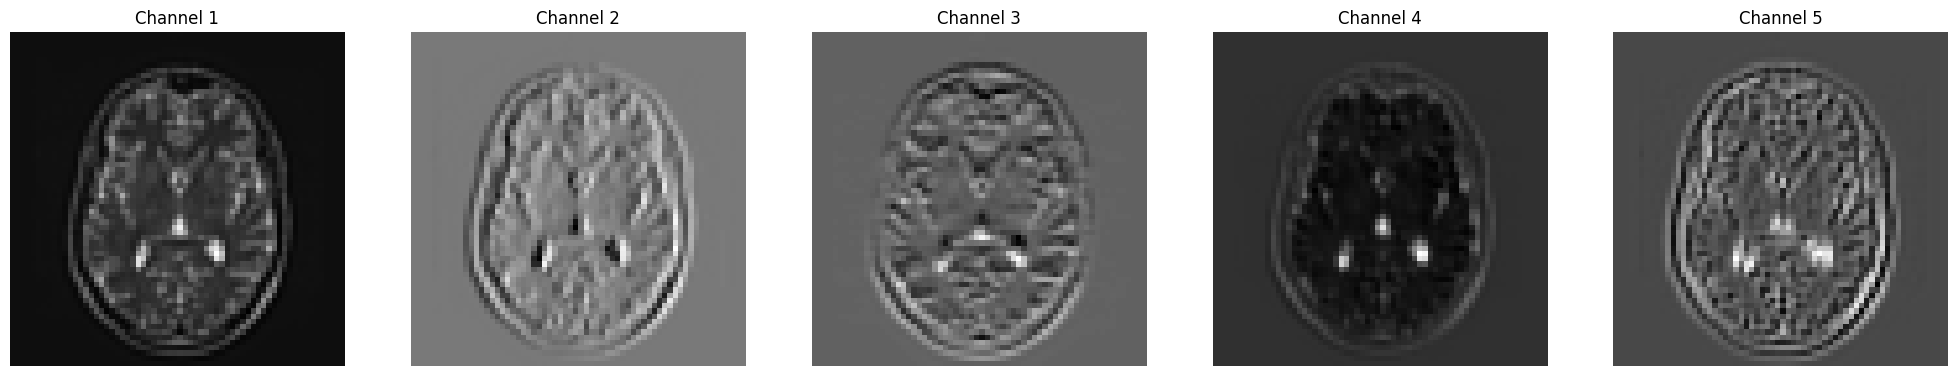

In [71]:
imshow_latent_images(out['downsample_layer_2'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


def imshow_latent_images(images):
    """Shows latent images with multiple channels as separate grayscale images.

    Args:
        images: numpy array of shape (1, C, H, W) where C is the number of channels, H is height, and W is width.
    """
    assert len(images.shape) == 4, "Input images should have 4 dimensions (1, C, H, W)"
    assert images.shape[0] == 1, "This function supports single image only"

    images = images.detach().cpu().numpy()
    num_channels = images.shape[1]

    if num_channels > 5:
        # perform PCA
        pca = PCA(n_components=5)
        _, C, H, W = images.shape
        reshaped_image = images.reshape(C, H * W)
        pca_result = pca.fit_transform(reshaped_image.T)
        pca_images = pca_result.T.reshape((-1, H, W))
        # Normalize each component to [0, 1]
        pca_images = (pca_images - pca_images.min(axis=(1, 2), keepdims=True)) / (
            pca_images.max(axis=(1, 2), keepdims=True)
            - pca_images.min(axis=(1, 2), keepdims=True)
        )
        images = pca_images[None]
    num_channels = images.shape[1]
    # Create a figure with sub-plots
    fig, axes = plt.subplots(1, num_channels, figsize=(num_channels * 5, 5))

    # Show each channel as a grayscale image
    for i in range(num_channels):
        channel_image = images[0, i, :, :]
        axes[i].imshow(channel_image, cmap="gray")
        axes[i].set_title(f"Channel {i+1}")
        axes[i].axis("off")

    # Show the figure
    plt.show()